In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import time
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import dill
import pickle
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shap



In [4]:
random_seed = 123


print("start")

df_eco = pd.read_csv('./Datasets/Microbes_only_Combined_cal_ifr_01.csv', sep=',', encoding='utf-8')
print(df_eco.head())



start
   Unnamed: 0   FIPS  unclassified_indoor_fungi  \
0           1  35001                       3445   
1           2  35001                       3081   
2           3  35001                       5112   
3           4  35001                       2513   
4           5  35001                       3523   

   k__Fungi.p__Ascomycota.c__Eurotiomycetes.o__Eurotiales.f__Trichocomaceae.g__Aspergillus_indoor  \
0                                                 17                                                
1                                                 36                                                
2                                                380                                                
3                                                 14                                                
4                                                 18                                                

   k__Fungi.p__Ascomycota.c__Dothideomycetes.o__Capnodiales.f__Incertae.sedis.g_

In [5]:
print(df_eco.describe())

        Unnamed: 0          FIPS  unclassified_indoor_fungi  \
count  1280.000000   1280.000000                1280.000000   
mean    640.500000  30900.017188                1917.315625   
std     369.648482  15343.245532                1051.002528   
min       1.000000   1009.000000                   0.000000   
25%     320.750000  18157.500000                1452.250000   
50%     640.500000  36037.000000                2019.500000   
75%     960.250000  42004.000000                2502.500000   
max    1280.000000  56001.000000                7524.000000   

       k__Fungi.p__Ascomycota.c__Eurotiomycetes.o__Eurotiales.f__Trichocomaceae.g__Aspergillus_indoor  \
count                                        1280.000000                                                
mean                                          557.350000                                                
std                                          1294.997779                                                
min         

In [6]:
y = df_eco['IFR']
print(y)

print("df_eco "+str(df_eco.shape))

X = df_eco.iloc[:,:-1]

print("X "+str(X.shape))

0       0.005300
1       0.005300
2       0.005300
3       0.005300
4       0.005300
          ...   
1275    0.005783
1276    0.003057
1277    0.005040
1278    0.006855
1279    0.001111
Name: IFR, Length: 1280, dtype: float64
df_eco (1280, 339)
X (1280, 338)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed) #, random_state=9# The seed was 'chosen' so test and training contain all labels: rn=3,4,8,9
print("train label deficit:",len(set(y)-set(y_train)),"test label deficit:",len(set(y)-set(y_test)))

print("shapes "+str(X_train.shape)+"\t"+str(X_test.shape)+"\t"+str(y_train.shape)+"\t"+str(y_test.shape))

train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

input_data_dump = [X, y, X_train, X_test, y_train, y_test]
pickle.dump(input_data_dump,open("input_data_dump_mocci", "wb" ) )

train label deficit: 62 test label deficit: 265
shapes (960, 338)	(320, 338)	(960,)	(320,)


In [38]:
modelstart = time.time()

print(f"Starting search at {modelstart}")
cb_model = CatBoostRegressor(loss_function='MAE',
                             iterations = 200,
                             verbose = 5,
                             learning_rate = 0.1,
                             depth = 3,
                             l2_leaf_reg = 0.5,
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             #bagging_temperature = 0.2,
                             #od_type = 'Iter',
                             #od_wait = 100
)

grid = {#'iterations': [100, 150, 200],
       'learning_rate': [0.175, 0.2, 0.25],
        'depth': [3, 4, 5],
        'l2_leaf_reg': [2, 2.5, 2.75]}
grid_search_result = cb_model.grid_search(grid, train_dataset)

lr = grid_search_result['params']['learning_rate']
de = grid_search_result['params']['depth']
l2 = grid_search_result['params']['l2_leaf_reg']

print(f"Trained grid search in {time.time() - modelstart}s")

print("lr, de, l2 "+str(lr)+", "+str(de)+", "+str(l2))




Starting search at 1615449166.7587452

bestTest = 0.001749025554
bestIteration = 194

0:	loss: 0.0017490	best: 0.0017490 (0)	total: 784ms	remaining: 20.4s

bestTest = 0.001718692692
bestIteration = 175

1:	loss: 0.0017187	best: 0.0017187 (1)	total: 1.53s	remaining: 19.1s

bestTest = 0.001760679482
bestIteration = 102

2:	loss: 0.0017607	best: 0.0017187 (1)	total: 2.3s	remaining: 18.4s

bestTest = 0.001700391264
bestIteration = 199

3:	loss: 0.0017004	best: 0.0017004 (3)	total: 3.05s	remaining: 17.6s

bestTest = 0.001689001204
bestIteration = 169

4:	loss: 0.0016890	best: 0.0016890 (4)	total: 3.79s	remaining: 16.7s

bestTest = 0.001799645128
bestIteration = 175

5:	loss: 0.0017996	best: 0.0016890 (4)	total: 4.53s	remaining: 15.9s

bestTest = 0.001821789689
bestIteration = 140

6:	loss: 0.0018218	best: 0.0016890 (4)	total: 5.27s	remaining: 15.1s

bestTest = 0.001715612496
bestIteration = 184

7:	loss: 0.0017156	best: 0.0016890 (4)	total: 6.02s	remaining: 14.3s

bestTest = 0.001824928166


In [39]:
cb_model = CatBoostRegressor(loss_function='MAE',
                             iterations = 1000,
                             verbose = 5,
                             learning_rate = lr,
                             depth = de,
                             l2_leaf_reg = l2,
                             #eval_metric = 'MCC',
                             random_seed = random_seed,
                             #bagging_temperature = 0.2,
                             #od_type = 'Iter',
                             #od_wait = 100
)

print(f"Starting search at {modelstart}")
cbmf = cb_model.fit(X_train,y_train)
print(f"Trained in {time.time() - modelstart}s")

Starting search at 1615449166.7587452
0:	learn: 0.0019356	total: 6.55ms	remaining: 6.54s
5:	learn: 0.0018268	total: 25.9ms	remaining: 4.29s
10:	learn: 0.0017615	total: 44.1ms	remaining: 3.97s
15:	learn: 0.0017136	total: 62.4ms	remaining: 3.83s
20:	learn: 0.0016420	total: 80.4ms	remaining: 3.75s
25:	learn: 0.0016099	total: 98.7ms	remaining: 3.7s
30:	learn: 0.0015769	total: 117ms	remaining: 3.65s
35:	learn: 0.0015183	total: 135ms	remaining: 3.62s
40:	learn: 0.0014917	total: 154ms	remaining: 3.59s
45:	learn: 0.0014521	total: 172ms	remaining: 3.58s
50:	learn: 0.0014176	total: 194ms	remaining: 3.61s
55:	learn: 0.0013892	total: 213ms	remaining: 3.58s
60:	learn: 0.0013633	total: 231ms	remaining: 3.55s
65:	learn: 0.0013385	total: 249ms	remaining: 3.52s
70:	learn: 0.0012984	total: 270ms	remaining: 3.53s
75:	learn: 0.0012847	total: 287ms	remaining: 3.49s
80:	learn: 0.0012445	total: 305ms	remaining: 3.46s
85:	learn: 0.0011700	total: 323ms	remaining: 3.43s
90:	learn: 0.0011507	total: 341ms	remaini

815:	learn: 0.0005520	total: 3.13s	remaining: 705ms
820:	learn: 0.0005511	total: 3.15s	remaining: 687ms
825:	learn: 0.0005496	total: 3.17s	remaining: 669ms
830:	learn: 0.0005488	total: 3.19s	remaining: 650ms
835:	learn: 0.0005473	total: 3.21s	remaining: 630ms
840:	learn: 0.0005462	total: 3.23s	remaining: 611ms
845:	learn: 0.0005450	total: 3.25s	remaining: 592ms
850:	learn: 0.0005435	total: 3.27s	remaining: 573ms
855:	learn: 0.0005420	total: 3.29s	remaining: 554ms
860:	learn: 0.0005410	total: 3.31s	remaining: 534ms
865:	learn: 0.0005393	total: 3.33s	remaining: 515ms
870:	learn: 0.0005383	total: 3.35s	remaining: 496ms
875:	learn: 0.0005376	total: 3.37s	remaining: 477ms
880:	learn: 0.0005368	total: 3.39s	remaining: 458ms
885:	learn: 0.0005357	total: 3.4s	remaining: 438ms
890:	learn: 0.0005350	total: 3.42s	remaining: 419ms
895:	learn: 0.0005343	total: 3.44s	remaining: 400ms
900:	learn: 0.0005328	total: 3.46s	remaining: 380ms
905:	learn: 0.0005319	total: 3.48s	remaining: 361ms
910:	learn: 0

In [40]:
pred_train = cb_model.predict(X_train)
rmseT = (np.sqrt(mean_squared_error(y_train, pred_train)))
r2T = r2_score(y_train, pred_train)
print("Testing performance:")
print('RMSE training: {:.2f}'.format(rmseT))
print('R2 training: {:.2f}'.format(r2T))



Testing performance:
RMSE training: 0.00
R2 training: 0.85


In [41]:
cbmf.feature_names = df_eco.columns[:-1]

In [42]:
pred_test = cb_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred_test)))
r2 = r2_score(y_test, pred_test)
print("Testing performance:")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))



Testing performance:
RMSE: 0.00
R2: 0.41


In [43]:
explainer_model = shap.TreeExplainer(cb_model)
explainer_fit = shap.TreeExplainer(cbmf)

In [44]:
data_output = [random_seed, cb_model, cbmf, pred_train, explainer_model, pred_test, explainer_fit]
pickle.dump(data_output,open("data_output_mocci_MAE", "wb" ) )

Text(0.5, 0, 'CatBoost Feature Importance')

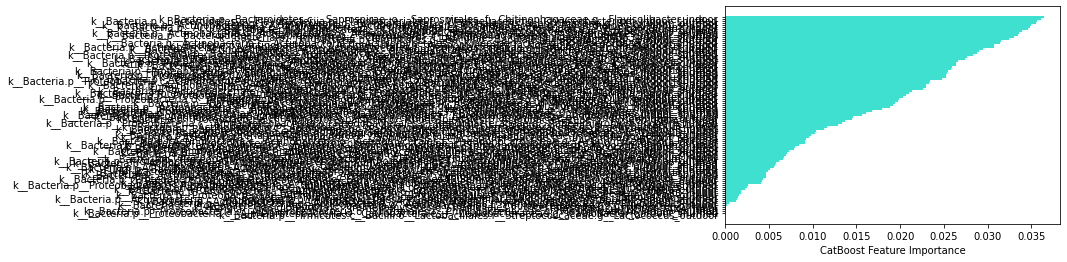

In [45]:
sorted_feature_importance = cb_model.feature_importances_.argsort()
plt.barh(cb_model.feature_names[sorted_feature_importance[1:100]],
        cb_model.feature_importances_[sorted_feature_importance[1:100]],
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

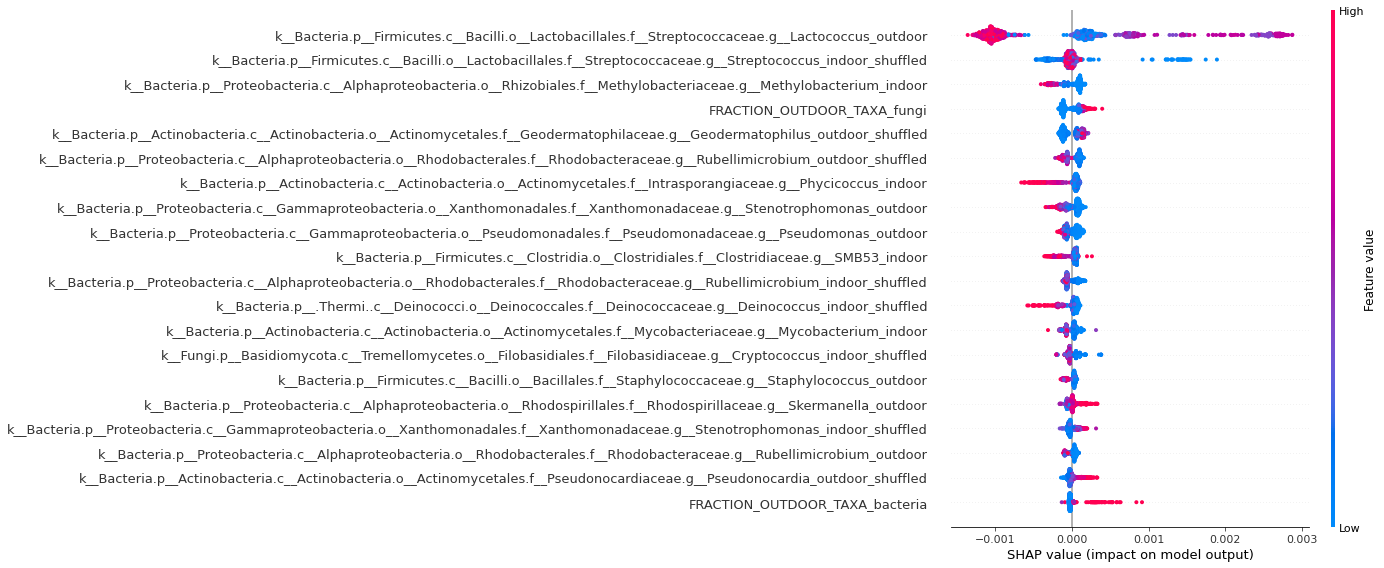

In [46]:
shap_values = explainer_model.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')


In [47]:
cbmf_all = cb_model.fit(X,y)

0:	learn: 0.0019458	total: 7.2ms	remaining: 7.2s
5:	learn: 0.0017742	total: 27.4ms	remaining: 4.53s
10:	learn: 0.0017283	total: 46.7ms	remaining: 4.2s
15:	learn: 0.0016537	total: 66.5ms	remaining: 4.09s
20:	learn: 0.0016178	total: 87.8ms	remaining: 4.09s
25:	learn: 0.0015965	total: 108ms	remaining: 4.03s
30:	learn: 0.0015746	total: 127ms	remaining: 3.98s
35:	learn: 0.0015457	total: 147ms	remaining: 3.94s
40:	learn: 0.0014954	total: 167ms	remaining: 3.9s
45:	learn: 0.0014651	total: 189ms	remaining: 3.92s
50:	learn: 0.0014221	total: 217ms	remaining: 4.04s
55:	learn: 0.0013949	total: 245ms	remaining: 4.12s
60:	learn: 0.0013757	total: 265ms	remaining: 4.08s
65:	learn: 0.0013323	total: 285ms	remaining: 4.03s
70:	learn: 0.0013178	total: 304ms	remaining: 3.98s
75:	learn: 0.0012892	total: 326ms	remaining: 3.96s
80:	learn: 0.0012681	total: 346ms	remaining: 3.92s
85:	learn: 0.0012534	total: 365ms	remaining: 3.88s
90:	learn: 0.0012409	total: 385ms	remaining: 3.85s
95:	learn: 0.0012278	total: 406m

835:	learn: 0.0006446	total: 3.52s	remaining: 690ms
840:	learn: 0.0006428	total: 3.54s	remaining: 669ms
845:	learn: 0.0006409	total: 3.56s	remaining: 647ms
850:	learn: 0.0006399	total: 3.58s	remaining: 626ms
855:	learn: 0.0006385	total: 3.6s	remaining: 605ms
860:	learn: 0.0006377	total: 3.62s	remaining: 584ms
865:	learn: 0.0006369	total: 3.64s	remaining: 563ms
870:	learn: 0.0006362	total: 3.66s	remaining: 542ms
875:	learn: 0.0006355	total: 3.68s	remaining: 521ms
880:	learn: 0.0006344	total: 3.7s	remaining: 500ms
885:	learn: 0.0006325	total: 3.73s	remaining: 480ms
890:	learn: 0.0006314	total: 3.75s	remaining: 459ms
895:	learn: 0.0006283	total: 3.77s	remaining: 438ms
900:	learn: 0.0006271	total: 3.79s	remaining: 417ms
905:	learn: 0.0006260	total: 3.81s	remaining: 396ms
910:	learn: 0.0006250	total: 3.83s	remaining: 375ms
915:	learn: 0.0006240	total: 3.85s	remaining: 353ms
920:	learn: 0.0006223	total: 3.88s	remaining: 333ms
925:	learn: 0.0006213	total: 3.9s	remaining: 311ms
930:	learn: 0.0

In [49]:
pred_all = cbmf_all.predict(X)
rmseA = (np.sqrt(mean_squared_error(y, pred_all)))
r2A = r2_score(y, pred_all)
print("All performance:")
print('RMSE training: {:.2f}'.format(rmseA))
print('R2 training: {:.2f}'.format(r2A))




All performance:
RMSE training: 0.00
R2 training: 0.80


In [50]:
explainer_all = shap.TreeExplainer(cbmf_all)

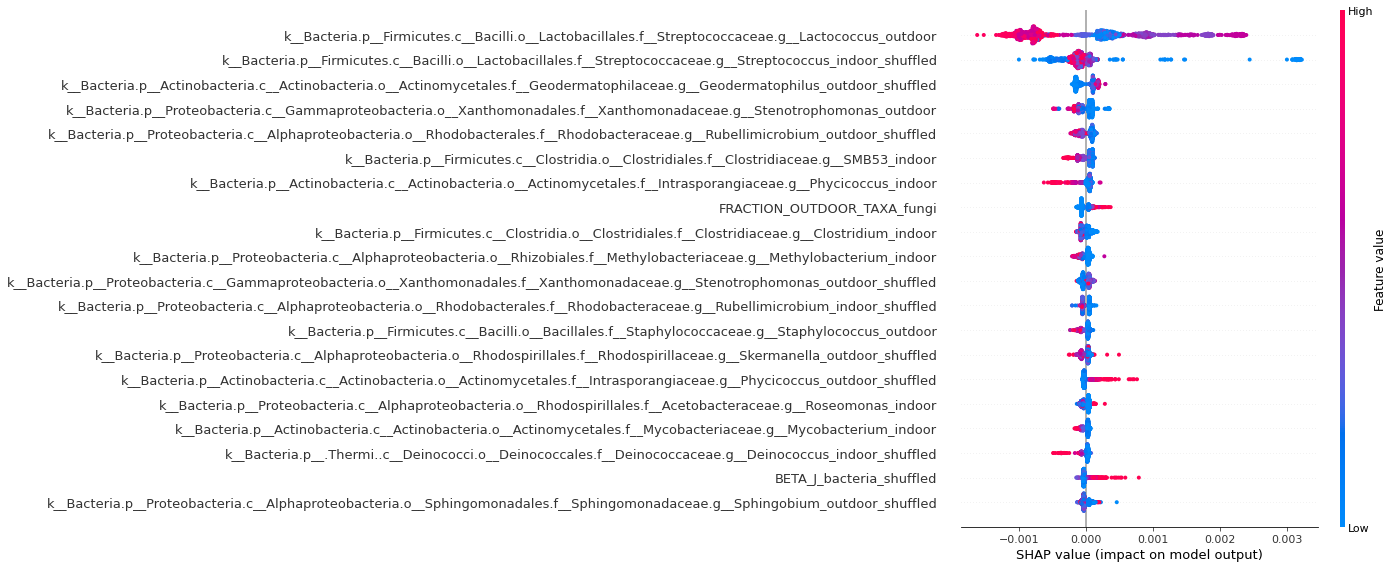

In [51]:
shap_values_all = explainer_all.shap_values(X)
shap.summary_plot(shap_values_all, X, feature_names = cb_model.feature_names[sorted_feature_importance],show=False)#,matplotlib=True).savefig('SHAP.pdf',bbox_inches = 'tight')

